In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from scipy.stats import multivariate_normal
from scipy.special import softmax

# Unsupervised learning

## Exercise 11.1: PCA on MNIST
In the lectures the principal component analysis (PCA) was introduced as a method for dimensionality reduction and feature extraction, i.e., to condense data by mapping it to a lower dimensional space of the most important features.

### Theoretical background

Let
\begin{equation*}
  \mathbf{X} = \begin{bmatrix} \mathbf{x}_1^\intercal \\ \vdots \\
    \mathbf{x}_N^\intercal \end{bmatrix} \in \mathbb{R}^{N \times D}
\end{equation*}
be a matrix of $N$ data samples $\mathbf{x}_n \in \mathbb{R}^D$, which are
centered around zero.
We consider a PCA with $M < D$ components.

To project the data points $\mathbf{x}_n$ to the $M$-dimensional space that is
defined by the $M$ principal components of $\mathbf{X}$, the so-called principal
subspace of $\mathbf{X}$, we can use the singular value decomposition of
$\mathbf{X}$. Let $\mathbf{X} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^\mathsf{T}$ be the
singular value decomposition of the data matrix $\mathbf{X}$ with the singular
values sorted in descending order.

Then the projection $\mathbf{z}_n$ of
data point $\mathbf{x}_n$ to the principal subspace of $\mathbf{X}$ is given by
\begin{equation}
  \mathbf{z}_n^\mathsf{T} = \mathbf{x}_n^\mathsf{T} \begin{bmatrix} \mathbf{v}_1 & \cdots & \mathbf{v}_M \end{bmatrix},
\end{equation}
where $\mathbf{v}_i$ is the $i$th column of matrix $\mathbf{V}$. The vector
$\mathbf{z}_n$ can be seen as an encoding of the data point
$\mathbf{x}_n$ in a lower dimensional space that is constructed by the directions
for which the data shows the largest variations.

With the help of the singular value decomposition of $\mathbf{X}$, we can also compute
reconstructions (or "decodings") $\tilde{\mathbf{x}}_n$ from the encodings $\mathbf{z}_n$ by
\begin{equation*}
  \tilde{\mathbf{x}}_n^\intercal = \mathbf{z}_n^\intercal \begin{bmatrix} \mathbf{v}^\intercal_1 \\ \vdots \\ \mathbf{v}^\intercal_M \end{bmatrix}.
\end{equation*}
If we use $M < D$ components, usually we are not able to recover the original data
from the lower dimensional encodings exactly. Ideally, we would like the
reconstructions to be as good as possible while keeping $M$ as small as possible.

##### Note

The singular value decomposition of a matrix $\mathbf{X} \in \mathbb{R}^{N \times D}$
is defined as a factorization of the form $\mathbf{X} = \mathbf{U} \mathbf{\Sigma}
\mathbf{V}^\mathsf{T}$ where $\mathbf{U} \in \mathbb{R}^{N \times N}$ and
$\mathbf{V} \in \mathbb{R}^{D \times D}$ are orthogonal matrices and
$\mathbf{\Sigma} \in \mathbb{R}^{N \times D}$ is a rectangular diagonal matrix with
non-negative numbers on the diagonal. The diagonal entries of $\mathbf{\Sigma}$ are
the so-called singular values of $\mathbf{X}$. A common convention is to sort
the singular values in descending order, in which case the diagonal matrix $\mathbf{\Sigma}$ is uniquely determined by $\mathbf{X}$.

### Introduction

In this exercise, we perform and analyse PCA of the MNIST image data set. The MNIST data set consists of 60000 training and 10000 test data points. Each data point consists of a grayscale image with 28 $\times$ 28 pixels of a handwritten digit. The digit has been size-normalized and centered within a fixed-sized image. Each image is also labeled with the digit (0, 1, ..., 8, or 9) it is depicting.

The following code block loads the MNIST data set.

In [2]:
# load MNIST data from https://www.openml.org/d/554
images, labels = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

# normalize images to [0,1]
images = images / 255

# convert labels to integers
labels = labels.astype(int)

# split into training and test dataset
train_images, train_labels = images[:60000], labels[:60000]
test_images, test_labels = images[60000:], labels[60000:]

The images are loaded as vectors $\mathbf{x} = [x_1 \dots x_{784}]^\mathsf{T}$ where each input variable $x_j$ corresponds to one of the $28 \times 28 = 784$ pixels in the image. The figure below shows the first 100 images in the training data set.

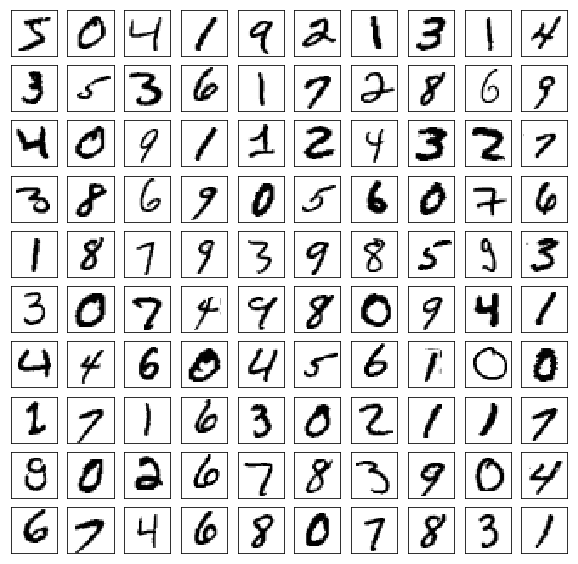

In [3]:
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10,10))
for image, ax in zip(train_images, axes.flat):
    ax.set_xticks(())
    ax.set_yticks(())
    ax.grid(False)
    ax.imshow(image.reshape(28,28), vmin=0.0, vmax=1.0, cmap='gray_r')
plt.show()

Let
\begin{equation*}
  \mathbf{X} = \begin{bmatrix} \mathbf{x}_1^\mathsf{T} \\ \vdots \\
    \mathbf{x}_{60000}^\mathsf{T} \end{bmatrix} \in \mathbb{R}^{60000 \times 784}
\end{equation*}
be a matrix of the MNIST training data set where each row $\mathbf{x}_i^\mathsf{T}$ represents an image of the training data set (all pixels are normalized to the interval $[0, 1]$). This matrix is huge, it contains $60000 \times 784 = 47040000$ entries!

Many entries in this matrix are zeros (corresponding to white pixels), and in particular the entries corresponding to white pixels close to the margins of an image are probably not informative and not relevant. In this exercise we will study how much information is lost if we compress the MNIST data set to $M = 2$ principal components.

We define the mean of the training images as
\begin{equation*}
    \overline{\mathbf{x}} = \frac{1}{60000} \sum_{i=1}^{60000} \mathbf{x}_i,
\end{equation*}
and hence the centered training images are given by $\mathbf{X} - \overline{\mathbf{x}}^\mathsf{T}$.

We compute the singular value decomposition $\mathbf{X} - \overline{\mathbf{x}}^\mathsf{T} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^\mathsf{T}$ of the centered MNIST training data with the function [`numpy.linalg.svd`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html).

In [4]:
# center training images
train_mean = train_images.mean(axis=0)

train_images_centered = train_images - train_mean

U, S, Vt = np.linalg.svd(train_images_centered, full_matrices=False)

Variable `S` contains the singular values of `train_images_centered`, in descending order.

In [5]:
# four largest singular values
S[:4]

array([554.08236184, 473.79289646, 441.76832659, 412.90967564])

Note that `Vt` correspods to $\mathbf{V}^\mathsf{T}$, i.e., it is the transpose of $\mathbf{V}$. We can recover `train_images_centered` from its singular value decomposition `U`, `S`, and `Vt`.

In [6]:
np.allclose(train_images_centered, U @ np.diag(S) @ Vt)

# alternative:
np.allclose(train_images_centered, (U * S) @ Vt)

True

### (a)

Compute the two-dimensional encodings of the images in the MNIST training and the test data set in the two-dimensional latent space spanned by the $M = 2$ principal components of the centered training data, the so-called principal subspace.

*Hints*:
- Make use of `U`, `S`, and/or `Vt`.
- Remember that the presence of the center $\overline{\textbf{x}}$ needs to be accounted for in the test data as well.

In [7]:
test_images_centered = test_images-train_mean

train_encodings = (train_images_centered @ Vt.T[:,:2])

test_encodings = (test_images_centered @ Vt.T[:,:2])

Generate 2D scatter plots of the encodings that show the clusters for different labels in the latent space. You can make use of the function `plot_encodings` below.

In [8]:
# plot `train_encodings` and `test_encodings` with colorcoding of the corresponding labels
def plot_encodings(train_encodings, train_labels, test_encodings, test_labels):
    # create two plots side by side
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    # plot encodings of training data
    ax = axes[0]
    ax.scatter(
        train_encodings[:, 0], train_encodings[:, 1],
        c=train_labels, cmap=plt.cm.tab10, vmin=-0.5, vmax=9.5, alpha=0.7
    )
    ax.set_xlabel("$z_1$")
    ax.set_ylabel("$z_2$")
    ax.set_title("training data")
    
    # plot encodings of test data
    ax = axes[1]
    scatter = ax.scatter(
        test_encodings[:, 0], test_encodings[:, 1],
        c=test_labels, cmap=plt.cm.tab10, vmin=-0.5, vmax=9.5, alpha=0.7
    )
    ax.set_xlabel("$z_1$")
    ax.set_ylabel("$z_2$")
    ax.set_title("test data")

    # add colorbar
    cb = fig.colorbar(scatter, ticks=range(10), ax=axes.ravel().tolist())
    cb.ax.set_title("digit")
    
    return fig

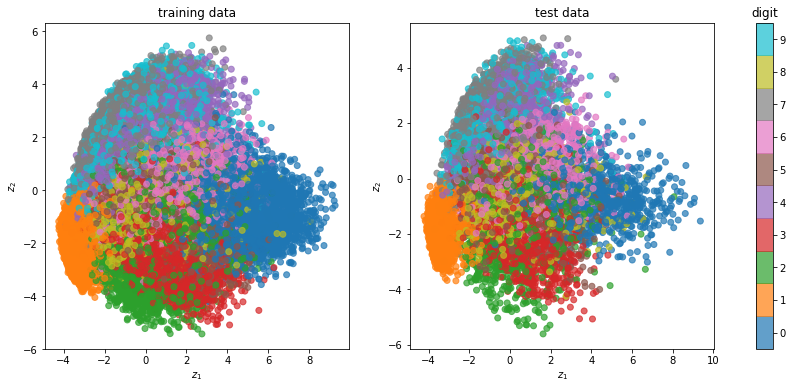

In [9]:
plot_encodings(train_encodings=train_encodings,
               train_labels=train_labels,
               test_encodings=test_encodings,
               test_labels=test_labels)

plt.savefig("../graph/pca.png")
plt.show()

**observation**: the distribution of decoding of training and test data is almost same.

### (b)

Compute the reconstructions of the test images by mapping the encodings of the test data from the latent space back to the space of images.

In [10]:
reconstruction_images = test_encodings@Vt[:2,:] + train_mean

In [11]:
reconstruction_images.shape

(10000, 784)

Plot some test images and their reconstructed counterparts. You can use the function `plot_reconstructions` below. Which digits can be reconstructed and decoded quite well, and which ones seem to be more challenging? Remember that the reconstructions are obtained by considering only the two principal components.

In [12]:
# plot a grid of random pairs of `originals` and `reconstructions`
def plot_reconstructions(originals, reconstructions, labels, num_rows=4, num_cols=2):
    # indices of displayed samples
    n = originals.shape[0]
    indices = np.random.choice(n, size=num_rows*num_cols, replace=False)

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 10))
    for (idx, ax) in zip(indices, axes.flat):
        # extract original, reconstruction, and label
        original = originals[idx]
        reconstruction = reconstructions[idx]
        label = labels[idx]

        # configure subplot
        ax.set_xticks(())
        ax.set_yticks(())
        ax.grid(False)
        ax.set_title(f"Label: {label}", fontweight='bold')

        # plot original and reconstructed image in a grid
        grid = np.ones((32, 62))
        grid[2:30, 2:30] = original.reshape(28, 28)
        grid[2:30, 32:60] = reconstruction.reshape(28, 28)
        ax.imshow(grid, vmin=0.0, vmax=1.0, cmap='gray_r')

    return fig

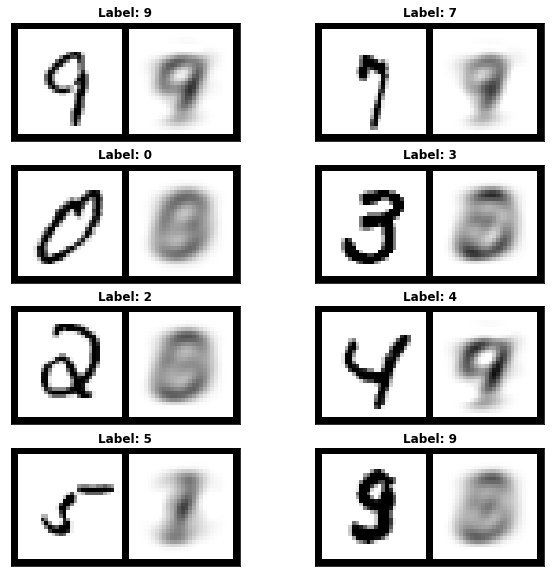

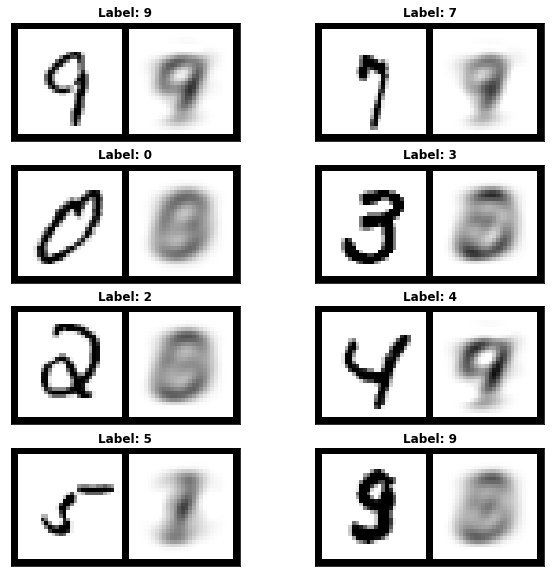

In [13]:
plot_reconstructions(test_images, reconstruction_images, test_labels)

### (c)

The comparison of the original images and their reconstructions provides us with some intuition for how much information is lost by the compression of the images to the two-dimensional latent space. As a less subjective measure we calculate the average squared reconstruction error
\begin{equation*}
\mathrm{sqerr} := \frac{1}{10000} \sum_{i=1}^{10000} \|\mathbf{x}_i - \tilde{\mathbf{x}}_i\|^2_2
\end{equation*}
of the images $\mathbf{x}_i \in {[0,1]}^{784}$ and their reconstructions $\tilde{\mathbf{x}}_i \in \mathbb{R}^{784}$ ($i = 1,\ldots, 10000$) in the MNIST test data set. An advantage of an objective measure such as the average squared reconstruction error is that it enables us to compare the PCA with other models for dimensionality reduction.

What average squared reconstruction error do you get with PCA?

In [14]:
sqerr = ((test_images-reconstruction_images)**2).sum(axis=1).mean()
print(sqerr)

43.64488141639828
